# Concave Function:

$reward = -rmse(state+action)$

Observations:
* Agents do better without batchnorm, because of the linearity of the objective function
* The optimal action is always $action = -state$
* With batchnorm, agents lose information about where in state space they are

In [1]:
from agentflow.env.simple import VecConcaveFuncEnv
from agentflow.agents import DDPG
from agentflow.buffers import BufferMap
from agentflow.state import NPrevFramesStateEnv
from agentflow.tensorflow.nn import dense_net
from agentflow.tensorflow.ops import normalize_ema
from agentflow.utils import check_whats_connected
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


## Settings


In [3]:
dqda_clipping = 1
clip_norm = True
hidden_dims = 32
hidden_layers = 3
output_dim = 1
batchnorm = True

## Build Environment & Agent

In [4]:
def dense_net(x,units,layers,batchnorm=True,activation=tf.nn.relu,training=False,**kwargs):

    assert isinstance(layers,int) and layers > 0, 'layers should be a positive integer'
    assert isinstance(units,int) and units > 0, 'units should be a positive integer'

    h = x
    for l in range(layers):
        h = tf.layers.dense(h,units,**kwargs)
        h = activation(h)
        
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
    return h

In [5]:
def build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm):
    def net_fn(state,training=False):
        h = state
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
        
            #with tf.control_dependencies(BN.updates):
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=batchnorm,training=training)
        else:
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=False,training=training)
            
        return tf.layers.dense(h,output_dim)
    return net_fn

def build_policy_fn(*args,**kwargs):
    return build_net_fn(*args,**kwargs)

def build_q_fn(*args,**kwargs):
    net_fn = build_net_fn(*args,**kwargs)
    def q_fn(state,action,training=False):
        h = tf.concat([state,action],axis=1)
        return net_fn(h)
    return q_fn

#### environment

In [6]:
env = VecConcaveFuncEnv()
state = env.reset()

state_shape = state.shape
action_shape = env.action_shape()
state_shape, action_shape

((4, 1), (4, 1))

#### neural nets

In [7]:
policy_fn = build_policy_fn(hidden_dims,hidden_layers,output_dim,batchnorm)
q_fn = build_q_fn(hidden_dims,hidden_layers,output_dim,batchnorm)

#### agent

In [8]:
tf.reset_default_graph()
agent = DDPG(state_shape[1:],action_shape[1:],policy_fn,q_fn,dqda_clipping,clip_norm)
replay_buffer = BufferMap()

W1212 21:23:01.532581 4625348032 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:43: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1212 21:23:01.551535 4625348032 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:59: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1212 21:23:01.633440 4625348032 deprecation.py:323] From <ipython-input-4-b7b951101ec6>:8: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1212 21:23:01.635318 4625348032 deprecation.py:506] From /Users/justinmaojones/rl/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer

## Test that we can learn Q with a time step of 1

In [9]:
agent.outputs

{'y': <tf.Tensor 'TDLearning/StopGradient:0' shape=<unknown> dtype=float32>,
 'td_error': <tf.Tensor 'TDLearning/sub:0' shape=<unknown> dtype=float32>,
 'loss': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
 'loss_Q': <tf.Tensor 'TDLearning/mul_1:0' shape=<unknown> dtype=float32>,
 'loss_policy': <tf.Tensor 'DpgLearning/mul:0' shape=(?,) dtype=float32>,
 'policy_train': <tf.Tensor 'policy/dense_3/BiasAdd:0' shape=(?, 1) dtype=float32>,
 'policy_eval': <tf.Tensor 'policy_1/dense_3/BiasAdd:0' shape=(?, 1) dtype=float32>,
 'Q_action_train': <tf.Tensor 'Reshape_2:0' shape=(?,) dtype=float32>,
 'Q_policy_train': <tf.Tensor 'Q_1/dense_3/BiasAdd:0' shape=(?, 1) dtype=float32>,
 'policy_ema': <tf.Tensor 'policy_2/dense_3/BiasAdd:0' shape=(?, 1) dtype=float32>,
 'Q_ema_state2': <tf.Tensor 'Reshape_3:0' shape=(?,) dtype=float32>}

In [10]:
opt_Q = tf.train.RMSPropOptimizer(1e-3)
update_op_Q = opt_Q.minimize(agent.outputs['loss_Q'])

In [11]:
lq = []
qq = []
rr = []
rrn = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    T = 1000
    pb = tf.keras.utils.Progbar(T)
    for i in range(T):
        pb.add(1)
        state = env.reset()
        action = state + 5*np.random.randn(*state.shape)        
        state2, reward, done, _ = env.step(action)
        done = np.ones_like(done)
        
        #if len(rr) > 0:
        if False:
            rm = np.mean(rr)
            rs = np.std(rr)
            reward_normalized = (reward-rm)/max(rs,1e-4)
        else:
            reward_normalized = reward

        #Q_action_train, loss_Q, y, r, gamma, Q_ema_state2 = sess.run(
        Q_action_train, loss_Q, _ = sess.run(
            [
                agent.outputs['Q_action_train'],
                agent.outputs['loss_Q'],
                update_op_Q,
        #        agent.outputs['y'],
        #        agent.inputs['reward'],
        #        agent.inputs['gamma'],
        #        agent.outputs['Q_ema_state2'],
            ],
            {
                agent.inputs['state']:state,
                agent.inputs['action']:action,
                agent.inputs['reward']:reward_normalized,
                agent.inputs['done']:done,
                agent.outputs['Q_ema_state2']:np.zeros_like(done),
                agent.inputs['state2']:state2,
                agent.inputs['gamma']:1.0,
                agent.inputs['ema_decay']:0.99,
            }
        )
        lq.append(loss_Q)
        qq.append(Q_action_train)
        rr.append(reward)
        rrn.append(reward_normalized)
        
        a = np.arange(-10,10,0.01)[:,None]
        s = np.ones_like(a)
        q_f = sess.run(
            agent.outputs['Q_action_train'],
            {
                agent.inputs['state']:s,
                agent.inputs['action']:a,
                
            }
        )
    

1000/1000 [==============================] - 2s 2ms/step


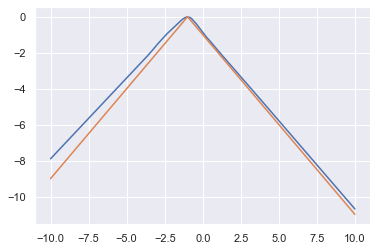

In [12]:
plt.plot(a,q_f)
plt.plot(a,env.compute_reward(a+1))

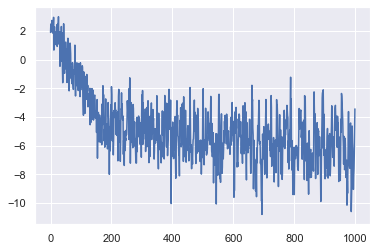

In [13]:
plt.plot(np.log(np.stack(lq).mean(axis=1)))

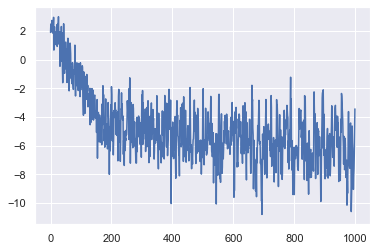

In [14]:
plt.plot(np.log(np.stack(lq).mean(axis=1)))

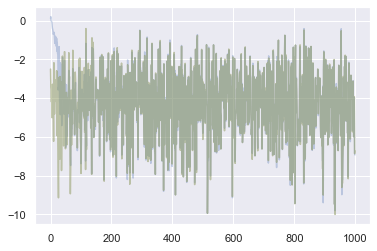

In [15]:
plt.plot(np.stack(qq).mean(axis=1),alpha=0.3)
plt.plot(np.stack(rr).mean(axis=1),alpha=0.3)
plt.plot(np.stack(rrn).mean(axis=1),alpha=0.3)

## Train Agent

In [16]:
VARVALS = {v.name:tf.reduce_mean(tf.square(v)) for v in tf.global_variables()}

In [17]:
reward_history = []
action_history = []
variable_vals = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    B = int(1e1)
    T = int(1e4)
    batchsize = B
    pb = tf.keras.utils.Progbar(T)
    for t in range(T):
        action = agent.act(state)
        action += 2.*np.random.randn(*action.shape)
        
        state2, reward, done, info = env.step(action)
        
        reward_history.append(reward)
        action_history.append(action)
        
        replay_buffer.append({'state':state,'action':action,'reward':reward,'done':done,'state2':state2})
        state = state2
        
        if len(replay_buffer) > B:
            agent.update(**replay_buffer.sample(batchsize))
            
            #if t % 1000 == 0:
        variable_vals.append(sess.run(VARVALS))
            
        pb.add(1,[('avg_reward', reward.mean()),('avg_action', action.mean())])
        
    s = np.arange(-10,10,0.1)[:,None]
    pe,pt = sess.run(
        [
            agent.outputs['policy_eval'],
            agent.outputs['policy_train'],
        ],
        {
            agent.inputs['state']:s,
        }
        
    )
        

10000/10000 [==============================] - 57s 6ms/step - avg_reward: -1.7035 - avg_action: 0.0018


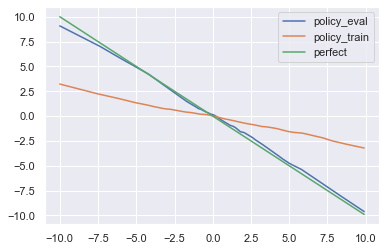

In [18]:
plt.plot(s,pe,label='policy_eval')
plt.plot(s,pt,label='policy_train')
plt.plot(s,-s,label='perfect')
plt.legend()

In [19]:
reward_history_arr = np.stack(reward_history)
action_history_arr = np.stack(action_history)
variable_vals_df = pd.DataFrame(variable_vals)

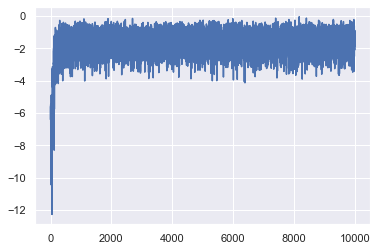

In [20]:
plt.plot(reward_history_arr.mean(axis=1))
#plt.plot(reward_history_arr.max(axis=1),alpha=0.2)

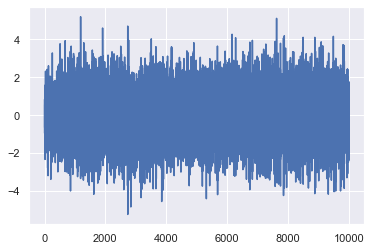

In [21]:
plt.plot(action_history_arr.mean(axis=1))

In [30]:
tf.global_variables()

[<tf.Variable 'policy/batch_normalization/gamma:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_mean:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_variance:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'policy/dense/kernel:0' shape=(1, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'po

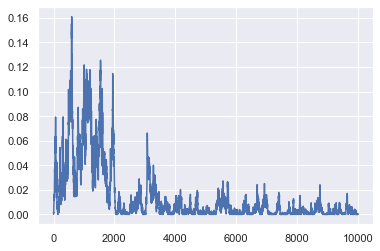

In [31]:
plt.plot(variable_vals_df['policy/batch_normalization/moving_mean:0'])

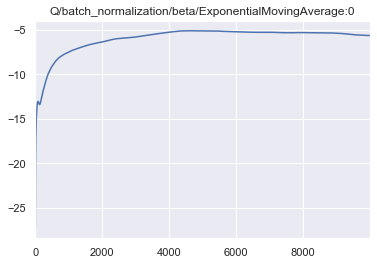

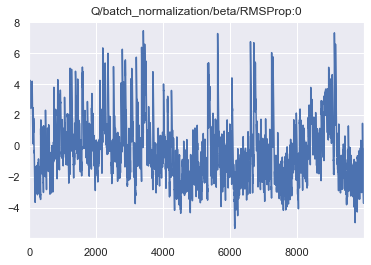

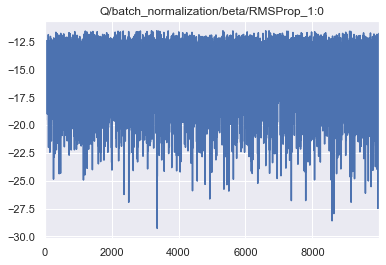

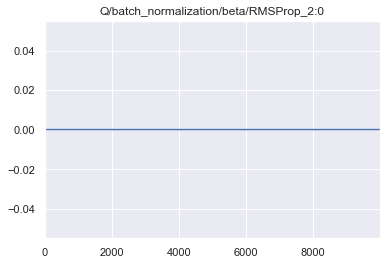

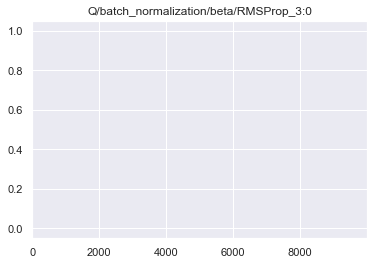

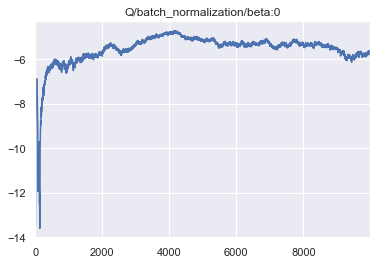

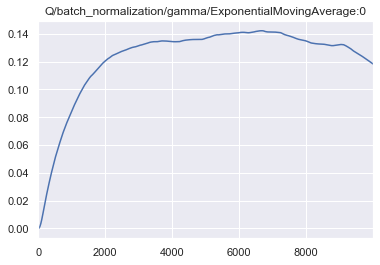

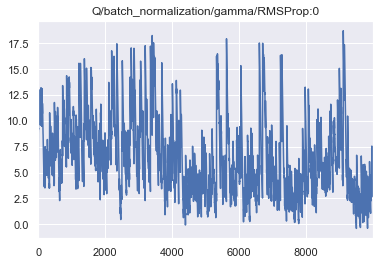

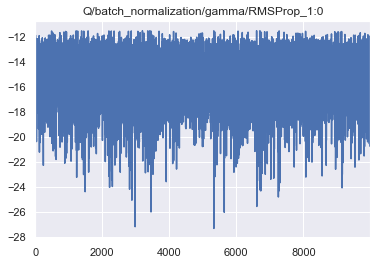

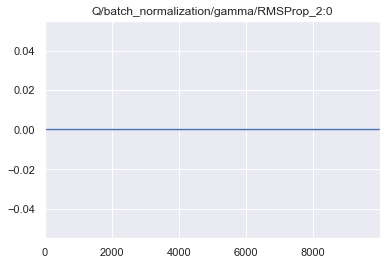

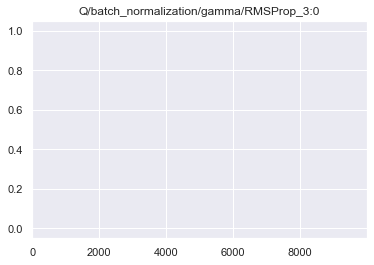

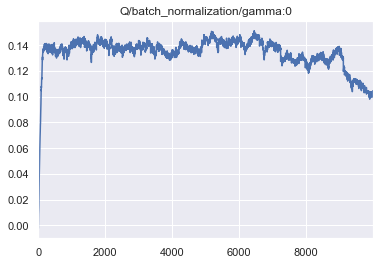

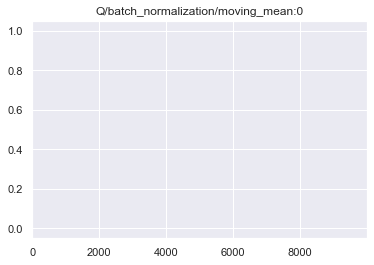

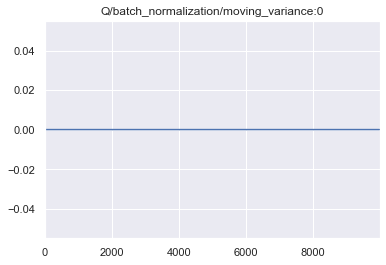

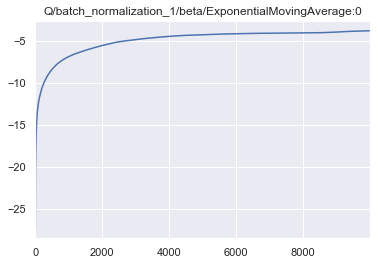

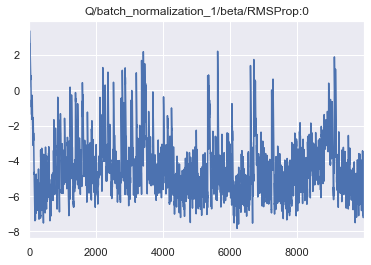

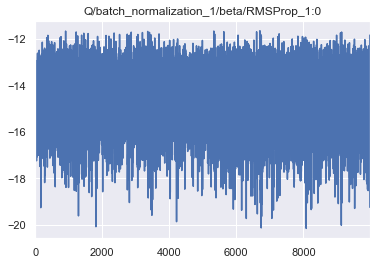

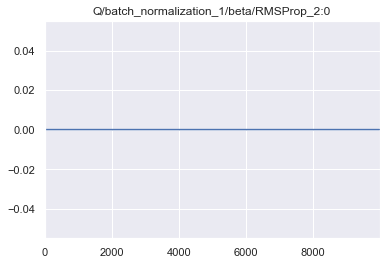

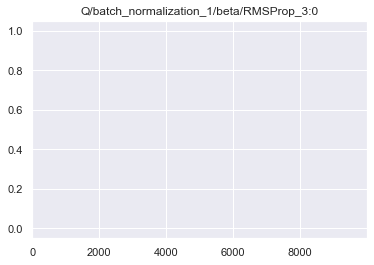

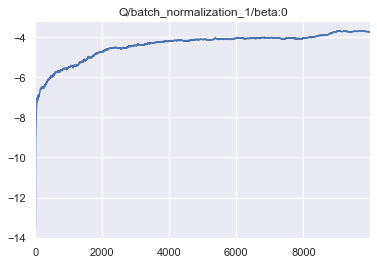

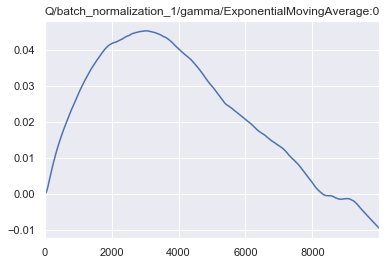

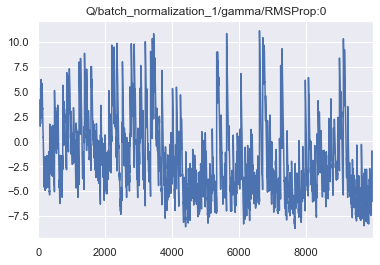

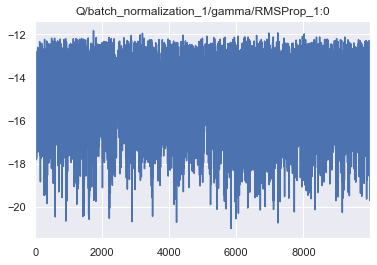

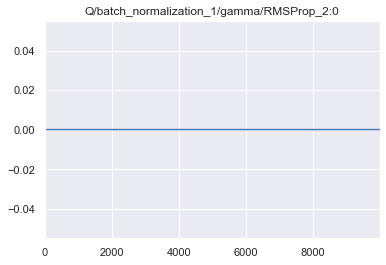

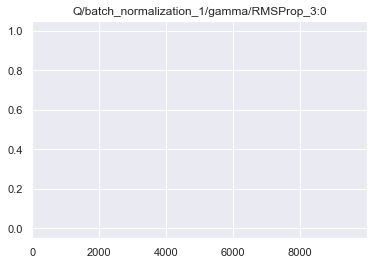

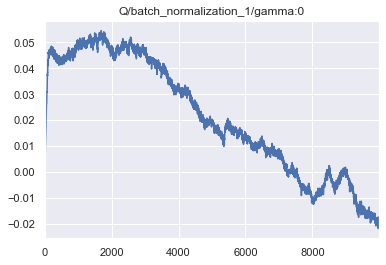

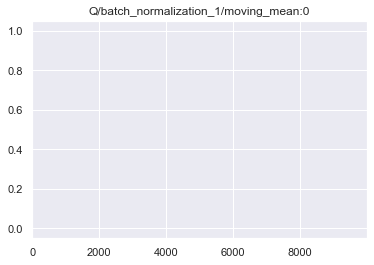

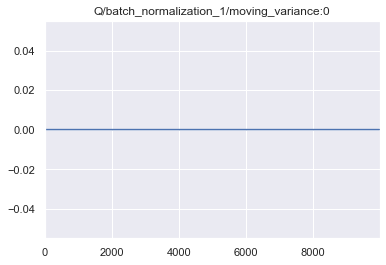

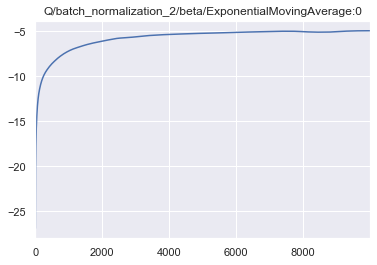

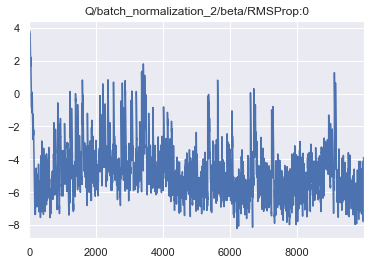

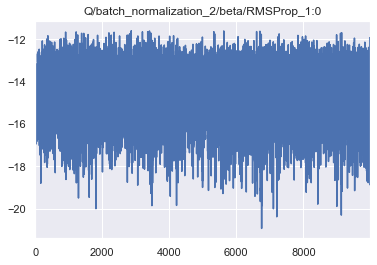

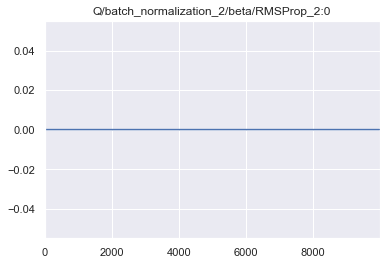

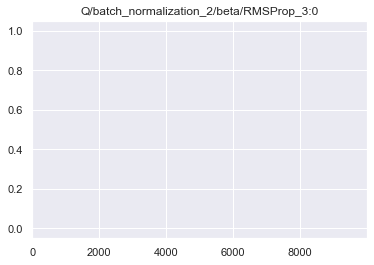

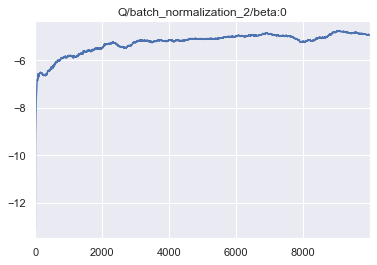

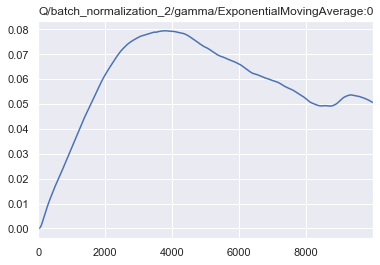

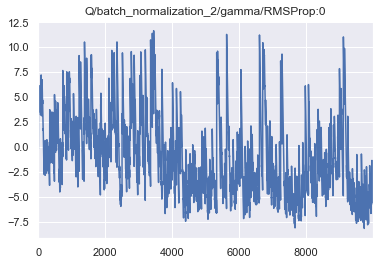

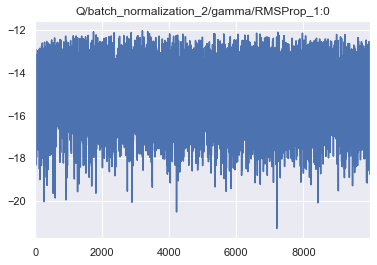

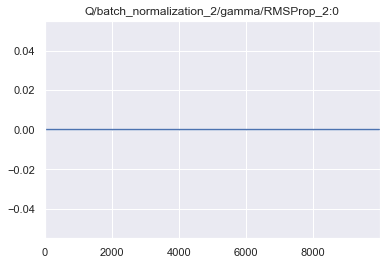

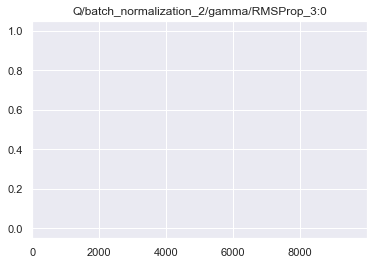

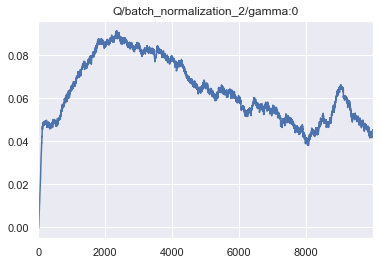

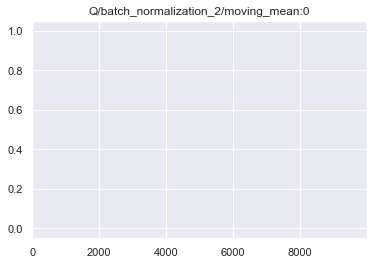

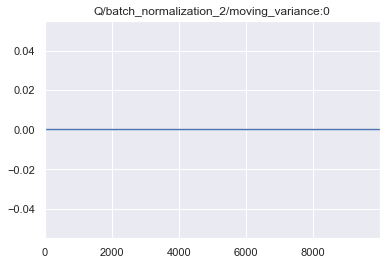

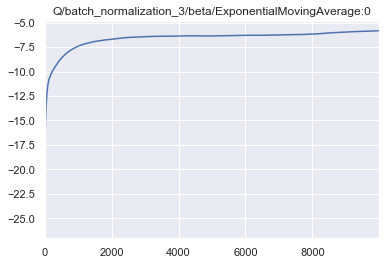

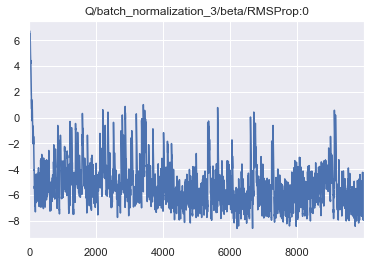

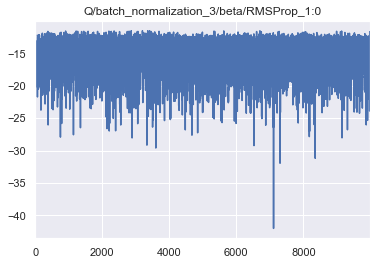

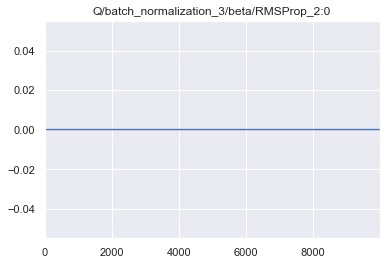

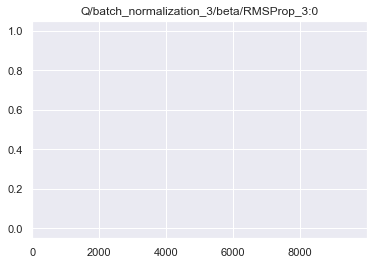

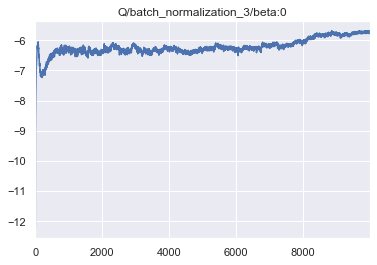

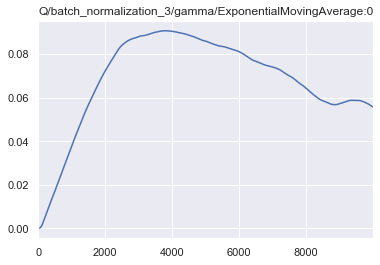

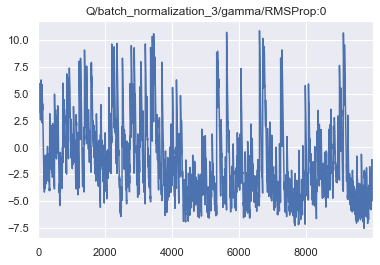

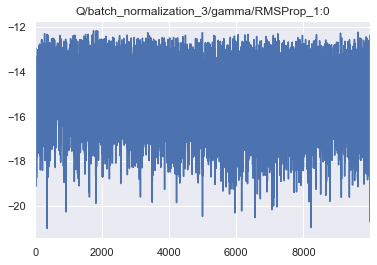

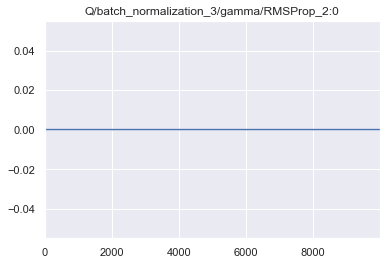

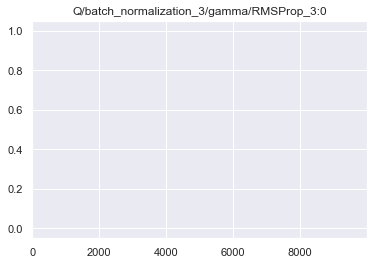

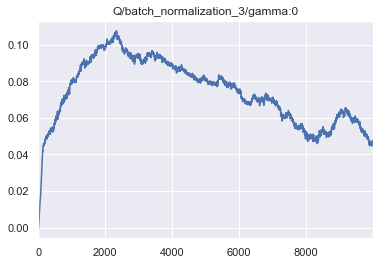

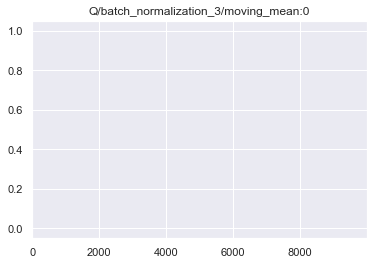

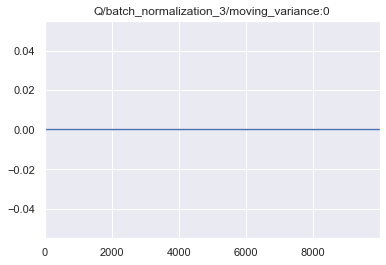

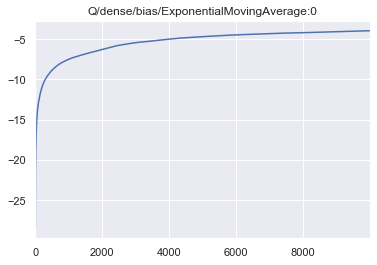

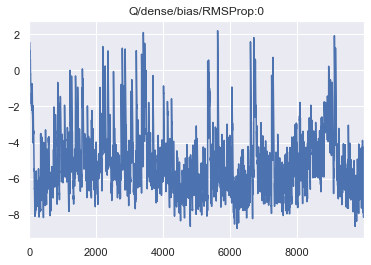

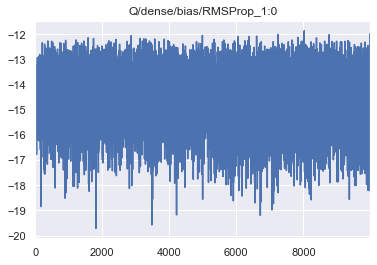

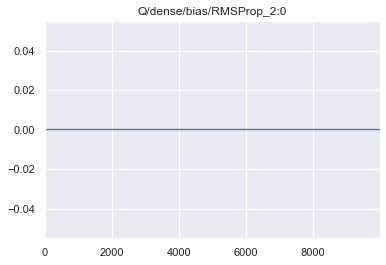

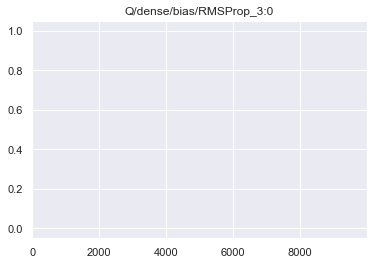

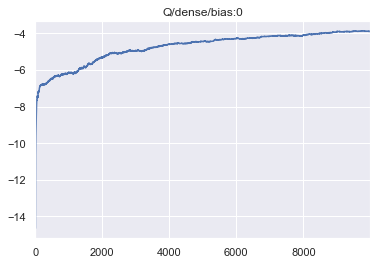

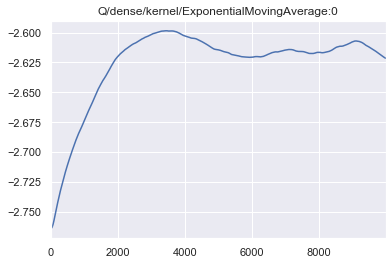

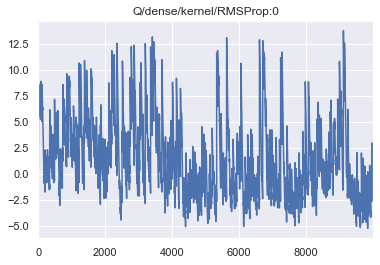

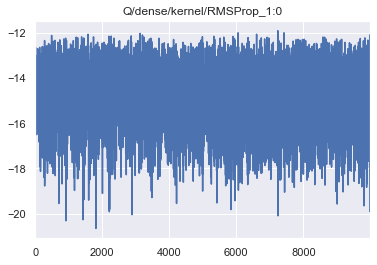

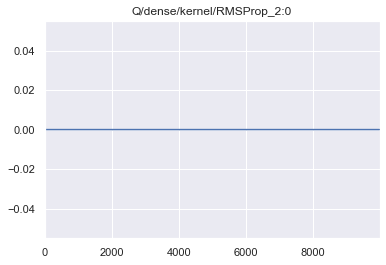

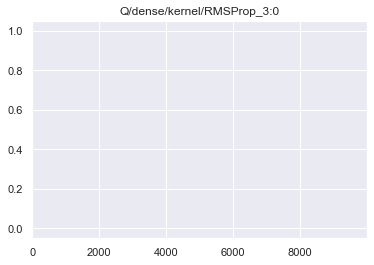

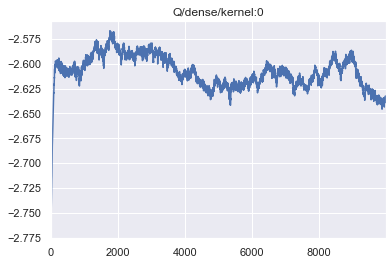

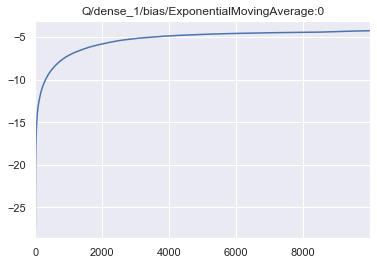

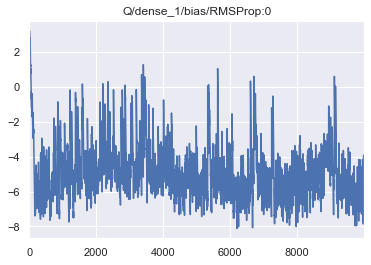

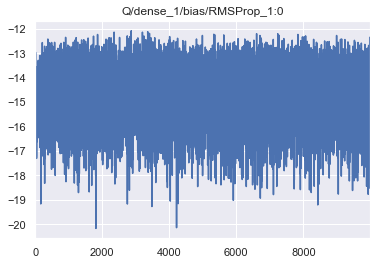

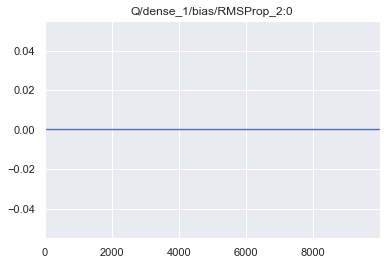

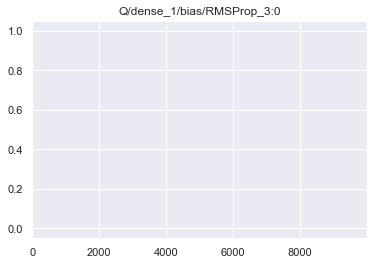

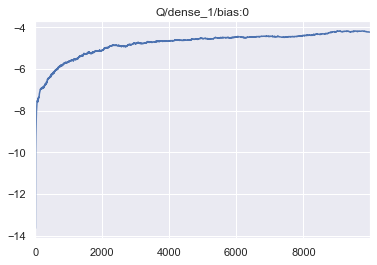

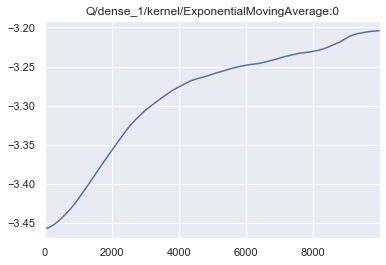

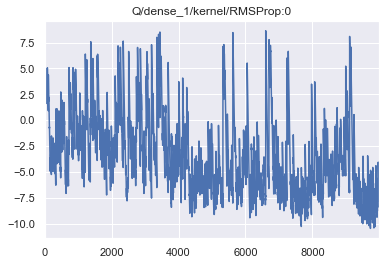

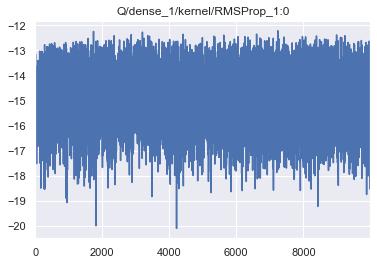

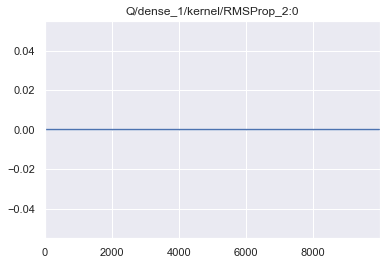

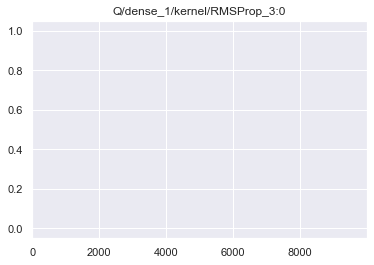

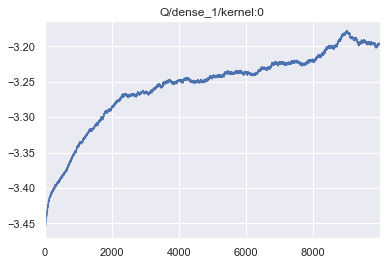

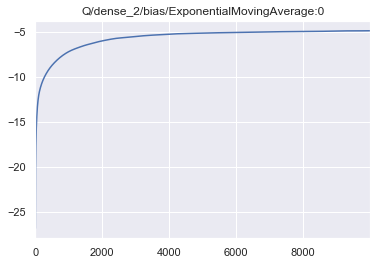

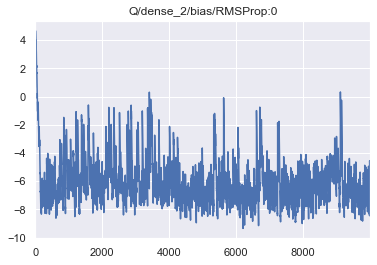

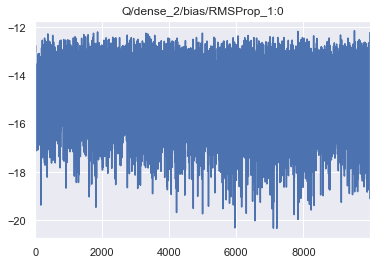

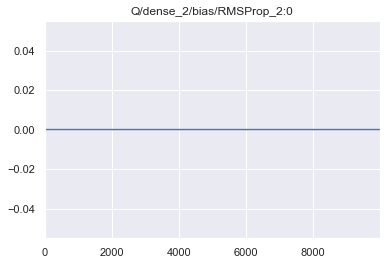

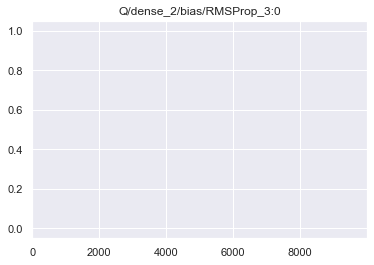

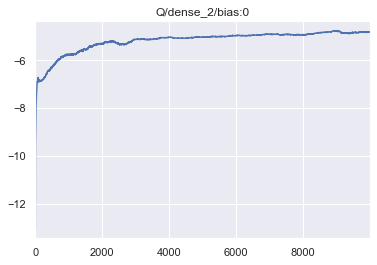

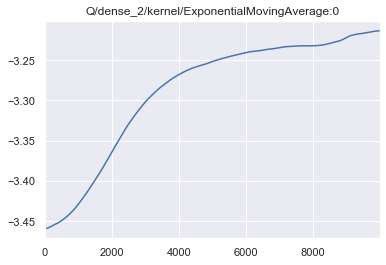

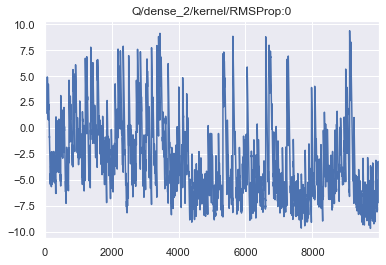

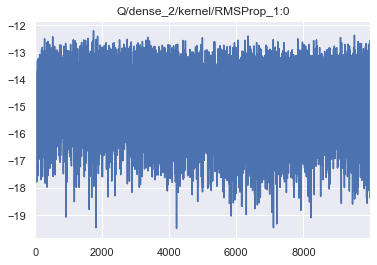

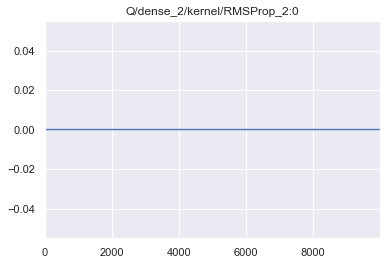

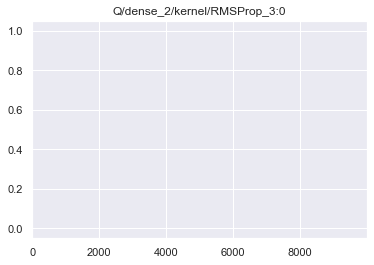

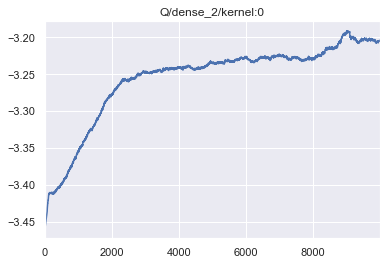

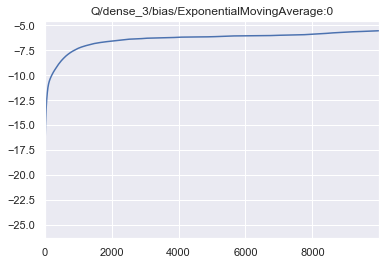

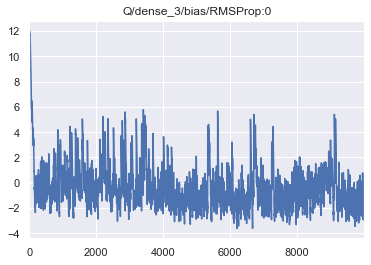

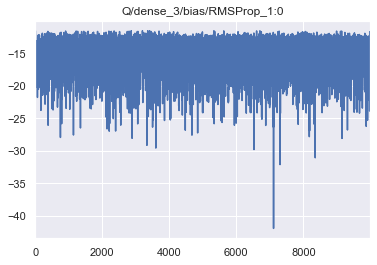

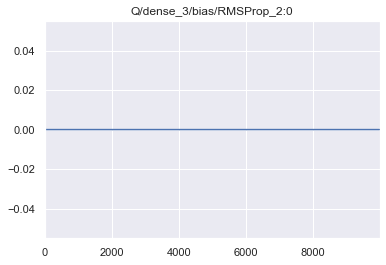

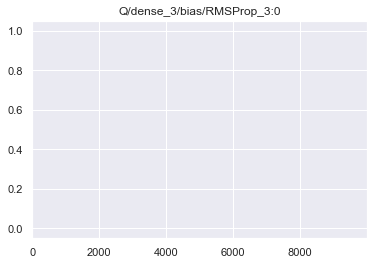

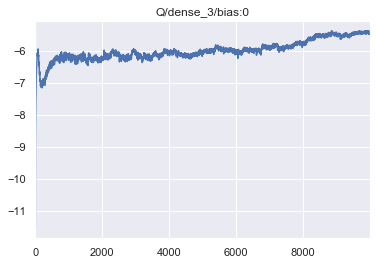

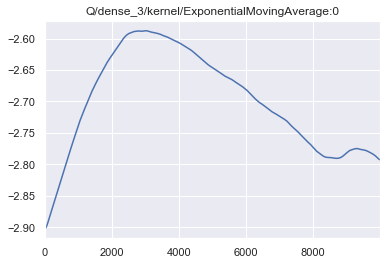

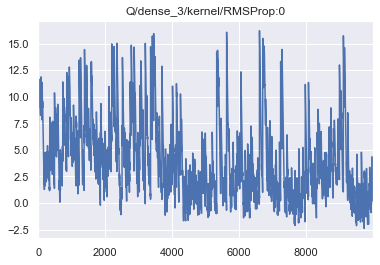

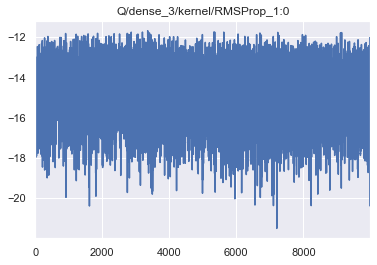

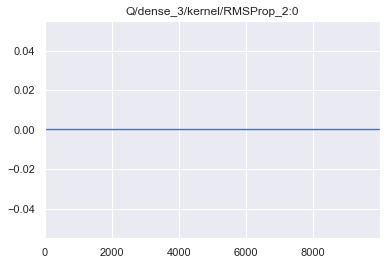

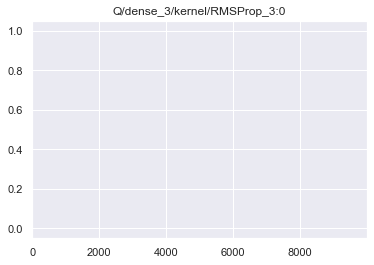

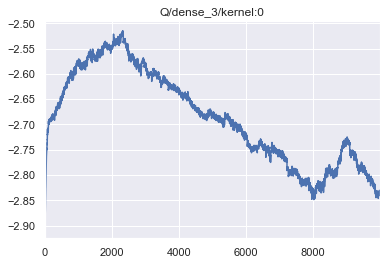

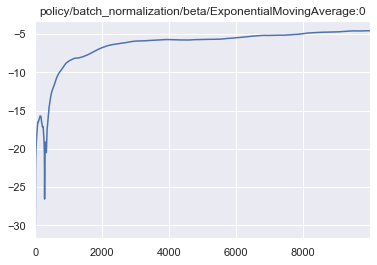

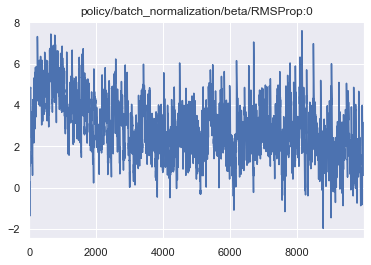

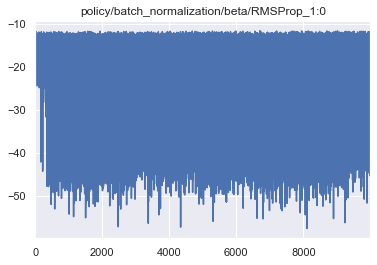

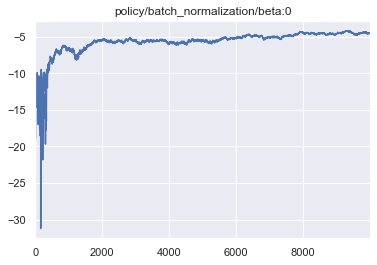

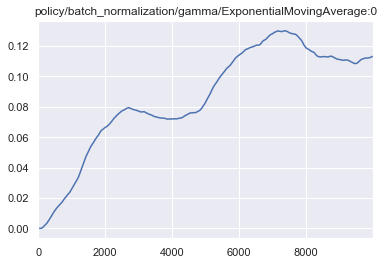

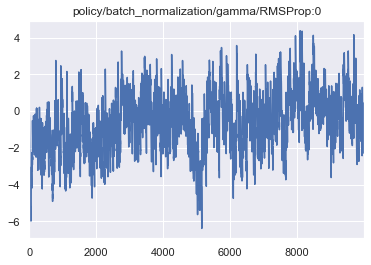

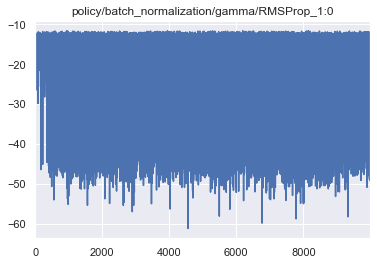

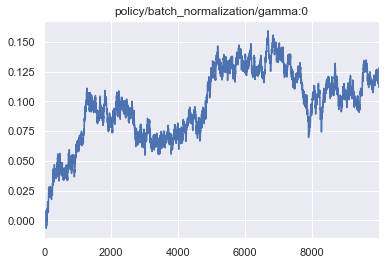

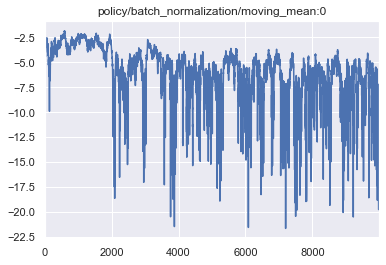

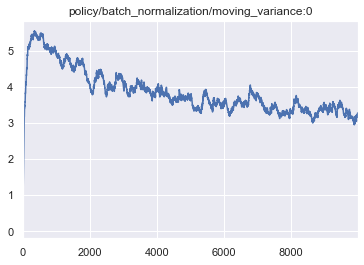

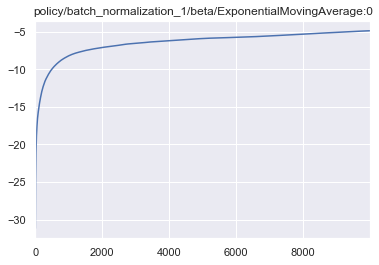

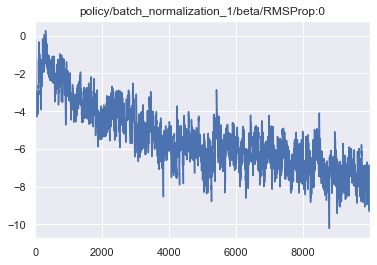

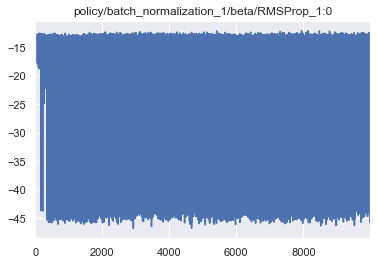

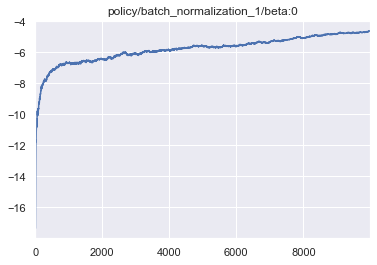

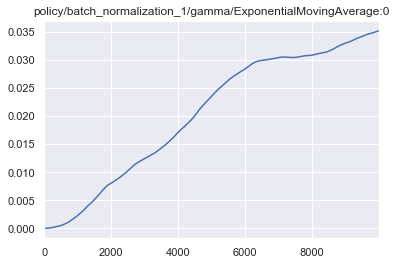

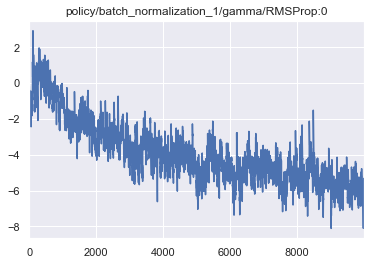

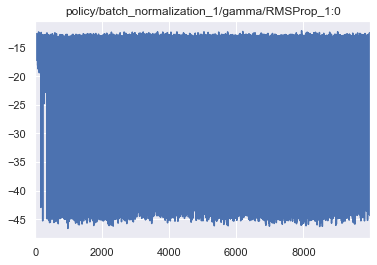

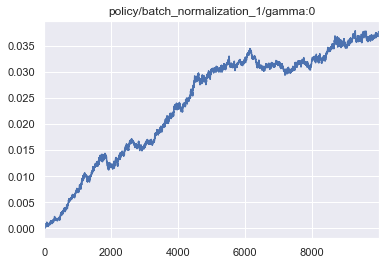

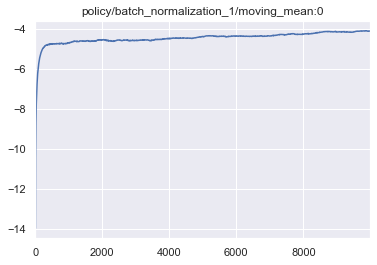

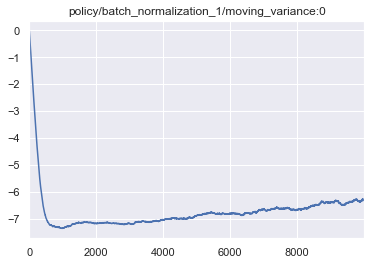

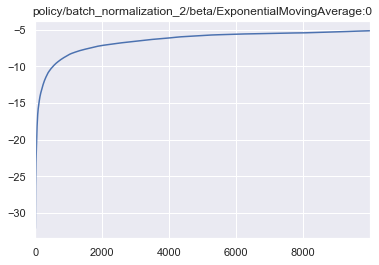

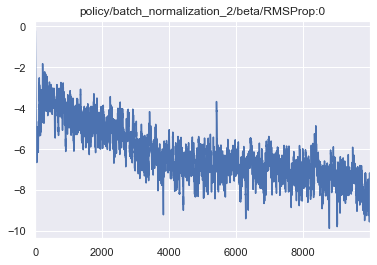

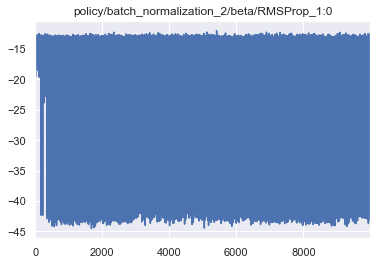

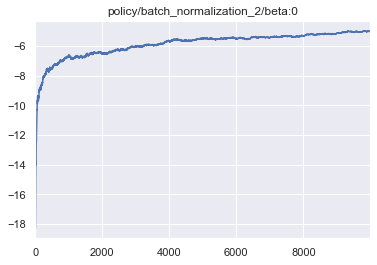

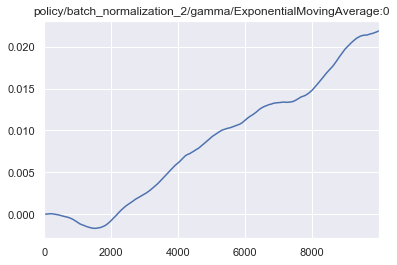

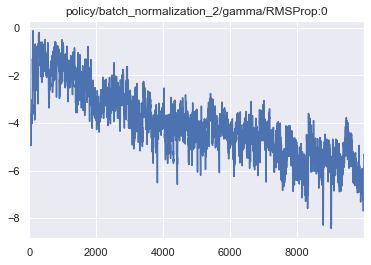

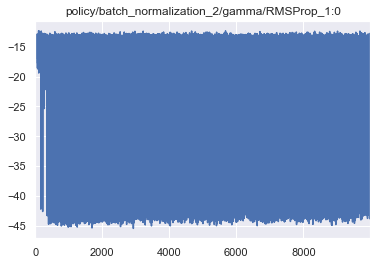

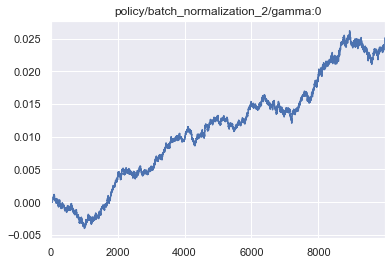

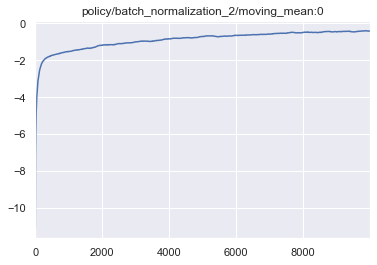

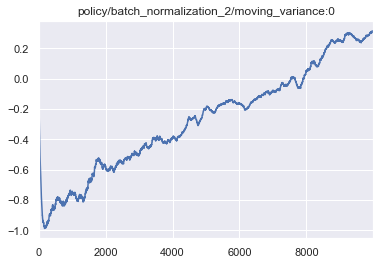

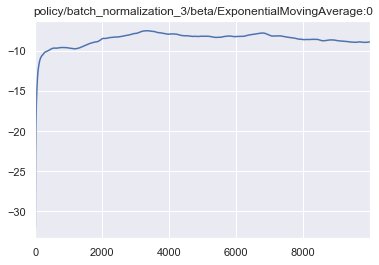

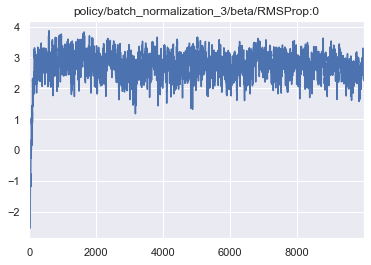

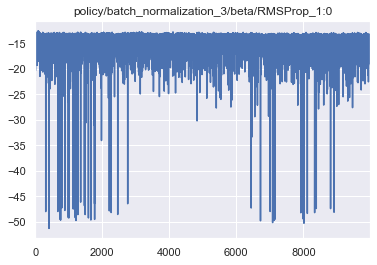

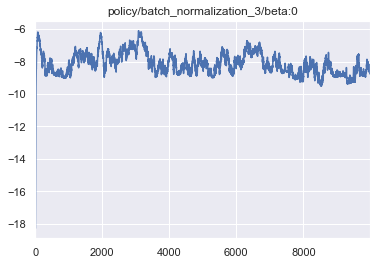

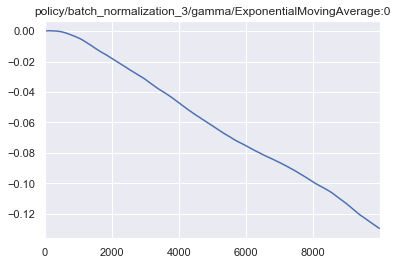

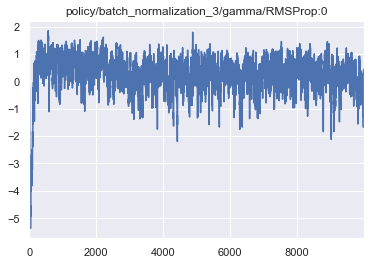

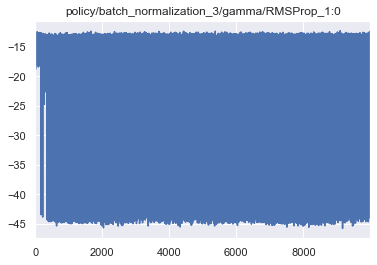

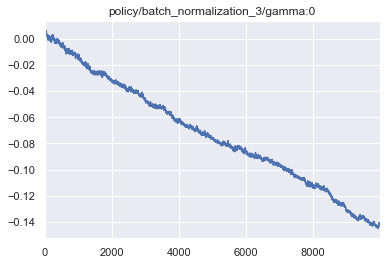

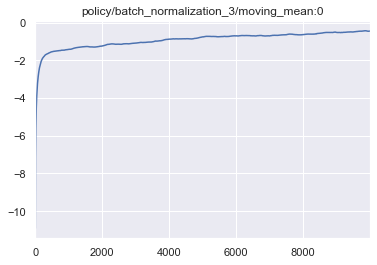

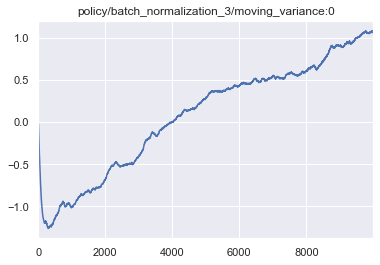

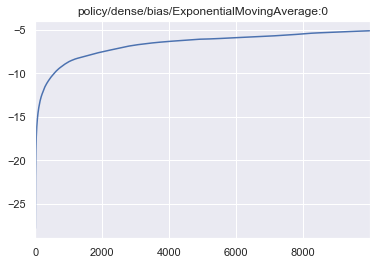

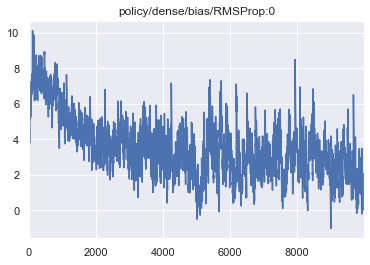

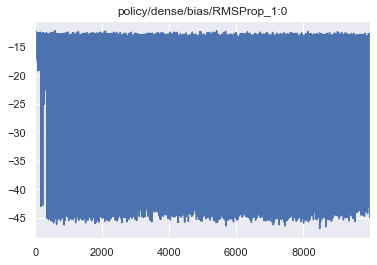

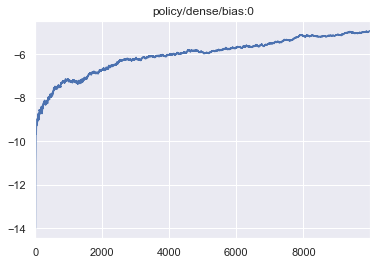

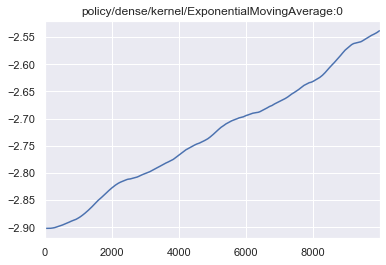

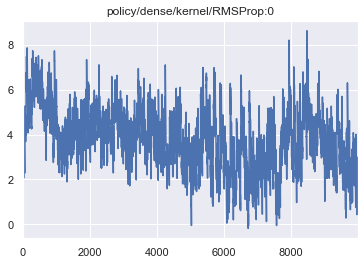

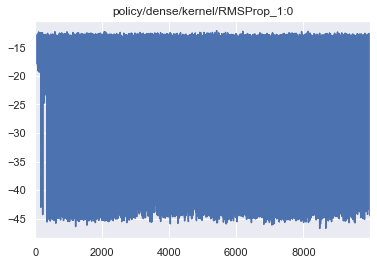

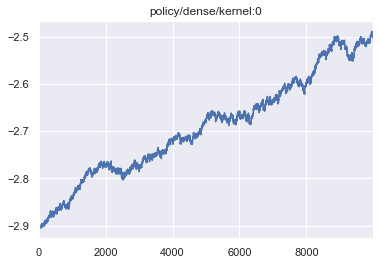

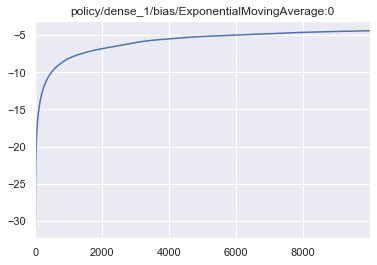

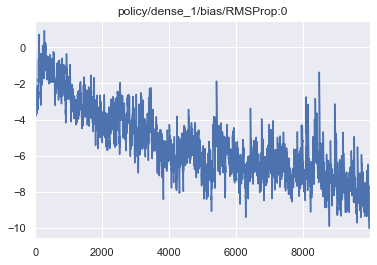

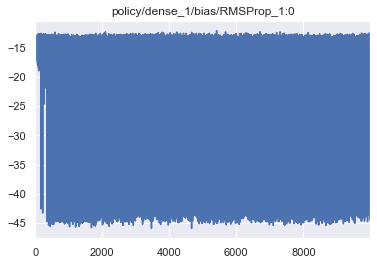

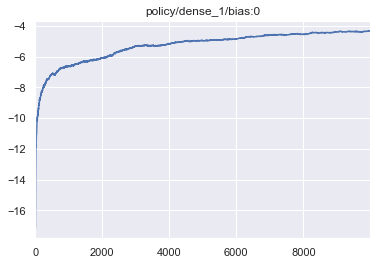

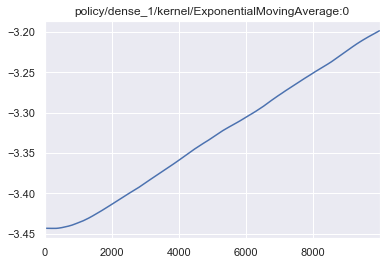

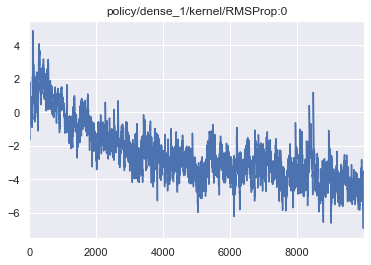

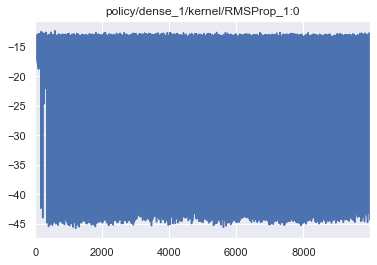

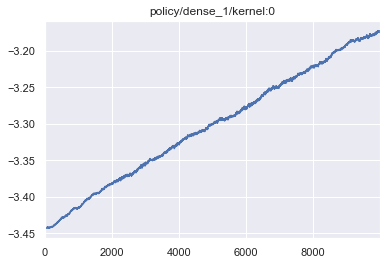

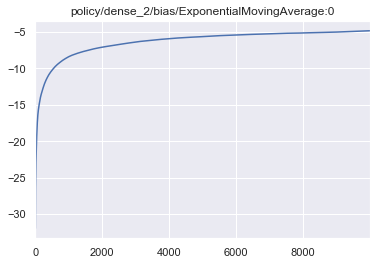

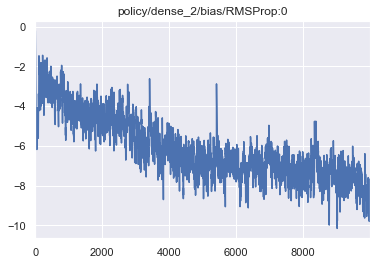

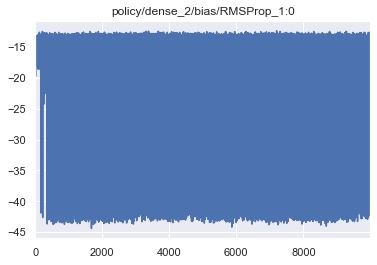

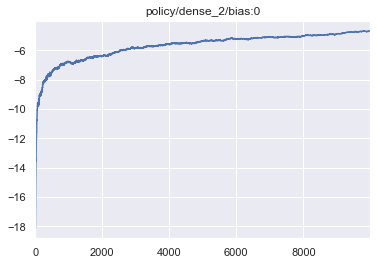

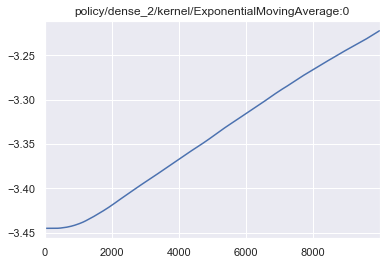

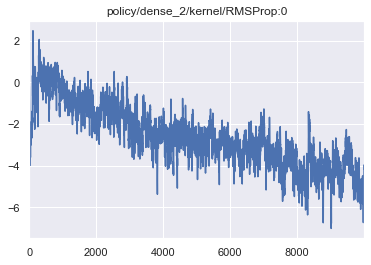

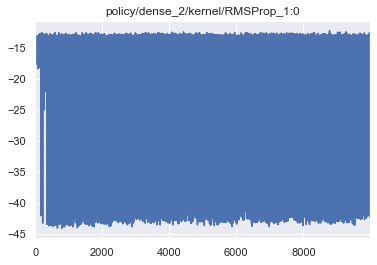

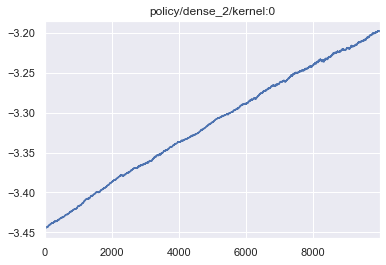

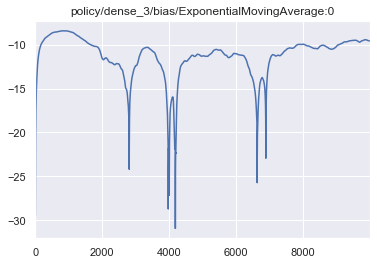

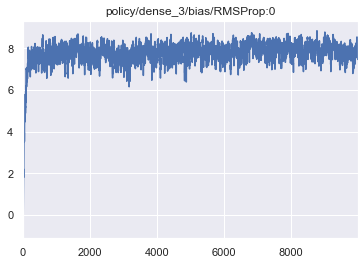

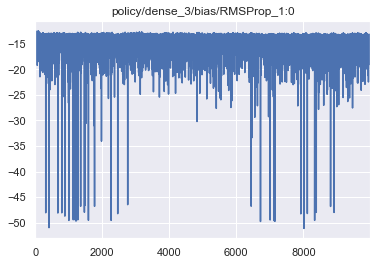

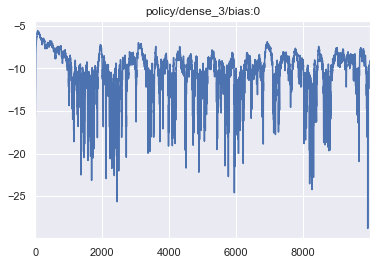

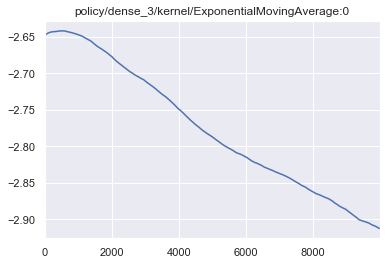

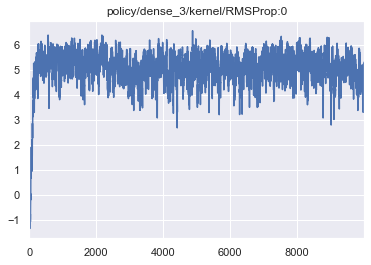

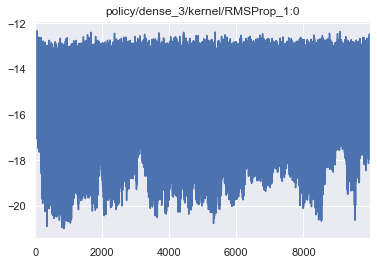

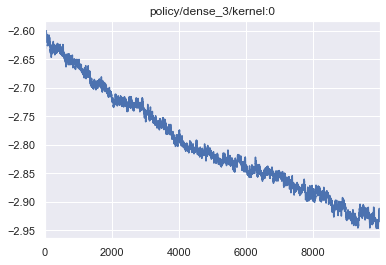

In [32]:
for c in sorted(variable_vals_df.columns):
    variable_vals_df[c].apply(np.log).plot(title=c)
    plt.show()